In [2]:


from io import BytesIO
import numpy as np
import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from google.protobuf import text_format

import caffe



def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [3]:
model_path = '/home/ozymandias/caffe/models/bvlc_googlenet/'
net_fn   = model_path + 'deploy.prototxt'
param_fn = model_path + 'bvlc_googlenet.caffemodel'

model = caffe.io.caffe_pb2.NetParameter()
text_format.Merge(open(net_fn).read(), model)
model.force_backward = True
open('tmp.prototxt', 'w').write(str(model))

net = caffe.Classifier('tmp.prototxt', param_fn,
                       mean = np.float32([104.0, 116.0, 122.0]), # ImageNet mean, training set dependent
                       channel_swap = (2,1,0)) # the reference model has channels in BGR order instead of RGB

def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']
def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

In [4]:
def objective_L2(dst):
    dst.diff[:] = dst.data 

def make_step(net, step_size=1.5, end='inception_4c/output', 
              jitter=32, clip=True, objective=objective_L2):
    '''Basic gradient ascent step.'''

    src = net.blobs['data'] # input image is stored in Net's 'data' blob
    dst = net.blobs[end]

    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    src.data[0] = np.roll(np.roll(src.data[0], ox, -1), oy, -2) # apply jitter shift
            
    net.forward(end=end)
    objective(dst)  # s optimization objective
    net.backward(start=end)
    g = src.diff[0]
    # apply normalized ascent step to the input image
    src.data[:] += step_size/np.abs(g).mean() * g

    src.data[0] = np.roll(np.roll(src.data[0], -ox, -1), -oy, -2) # unshift image
            
    if clip:
        bias = net.transformer.mean['data']
        src.data[:] = np.clip(src.data, -bias, 255-bias)

In [5]:
def deepdream(net, base_img, iter_n=10, octave_n=12, octave_scale=1.4, 
              end='inception_4c/output', clip=True, **step_params):
    # prepare base images for all octaves
    octaves = [preprocess(net, base_img)]
    for i in range(octave_n-1):
        octaves.append(nd.zoom(octaves[-1], (1, 1.0/octave_scale,1.0/octave_scale), order=1))
    
    src = net.blobs['data']
    detail = np.zeros_like(octaves[-1]) # allocate image for network-produced details
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        if octave > 0:
            # upscale details from the previous octave
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=1)

        src.reshape(1,3,h,w) # resize the network's input image size
        src.data[0] = octave_base+detail
        for i in range(iter_n):
            make_step(net, end=end, clip=clip, **step_params)
            
            # visualization
            vis = deprocess(net, src.data[0])
            if not clip: # adjust image contrast if clipping is disabled
                vis = vis*(255.0/np.percentile(vis, 99.98))
            showarray(vis)
            print (octave, i, end, vis.shape)
            clear_output(wait=True)
            
        # extract details produced on the current octave
        detail = src.data[0]-octave_base
    # returning the resulting image
    return deprocess(net, src.data[0])

# Controled Dream

In [6]:
layer=['inception_3a/output','inception_3b/output','inception_4a/output','inception_4b/output','inception_4c/output',
      'inception_4d/output','inception_4e/output','inception_5a/output','inception_5b/output']

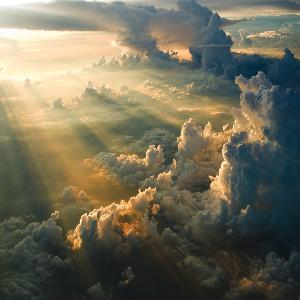

In [6]:
guide = PIL.Image.open('sky.jpg')
guide=guide.resize([300,300])
guide=np.float32(guide)
showarray(guide)

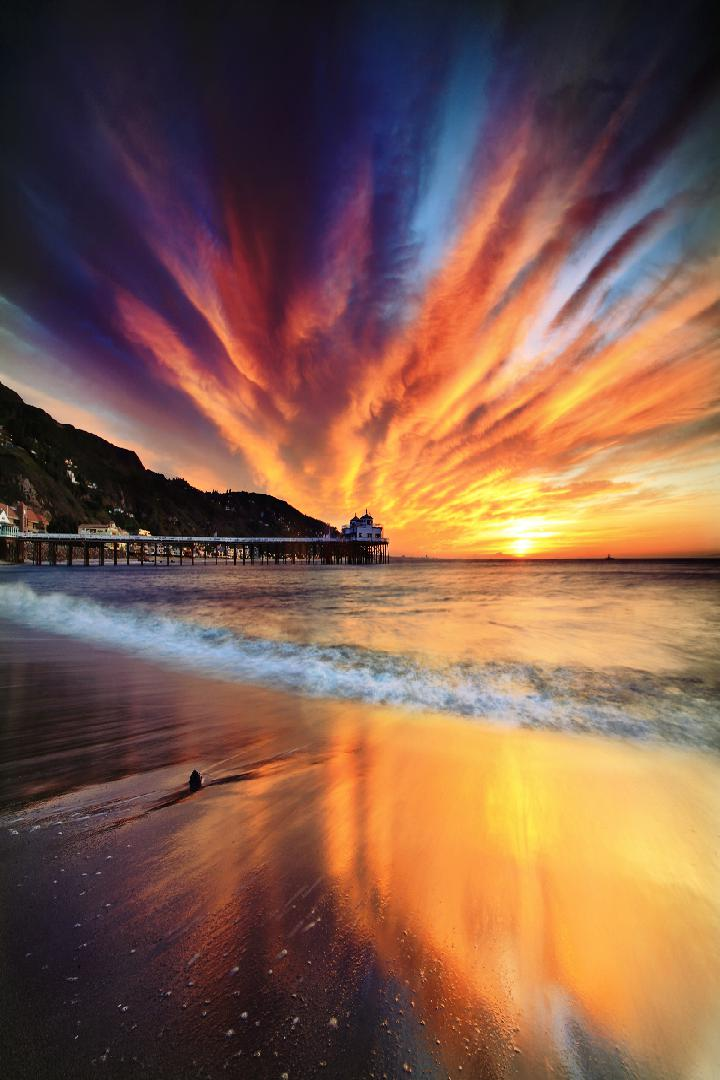

In [11]:
img = PIL.Image.open('ma.jpg')
img=img.resize([720,1080])
img=np.float32(img)
showarray(img)

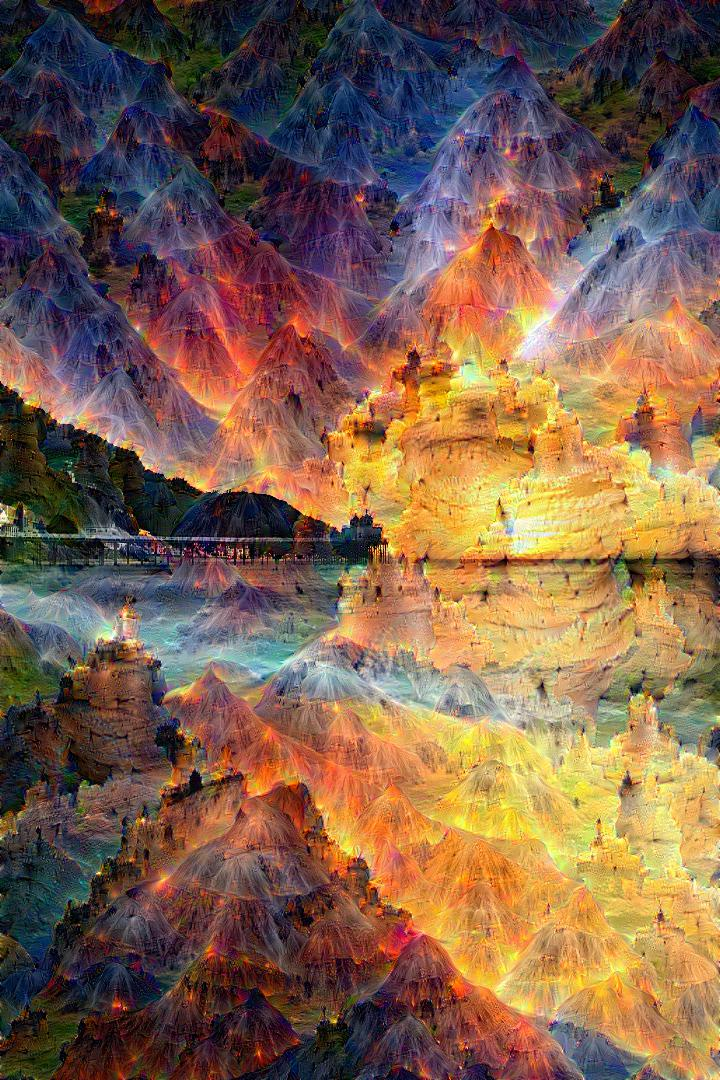

7 34 inception_4d/output (1080, 720, 3)


In [13]:
end = layer[5]
h, w = guide.shape[:2]
src, dst = net.blobs['data'], net.blobs[end]
src.reshape(1,3,h,w)
src.data[0] = preprocess(net, guide)
net.forward(end=end)
guide_features = dst.data[0].copy()

def objective_guide(dst):
    x = dst.data[0].copy()
    y = guide_features
    ch = x.shape[0]
    x = x.reshape(ch,-1)
    y = y.reshape(ch,-1)
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    dst.diff[0].reshape(ch,-1)[:] = y[:,A.argmax(1)] # select ones that match best

output=deepdream(net, img, end=end, objective=objective_guide,octave_n=8,iter_n=35)

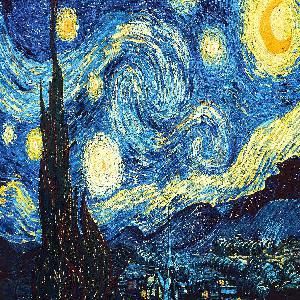

In [22]:
guide = PIL.Image.open('starry_night.jpg')
guide=guide.resize([300,300])
guide=np.float32(guide)
showarray(guide)

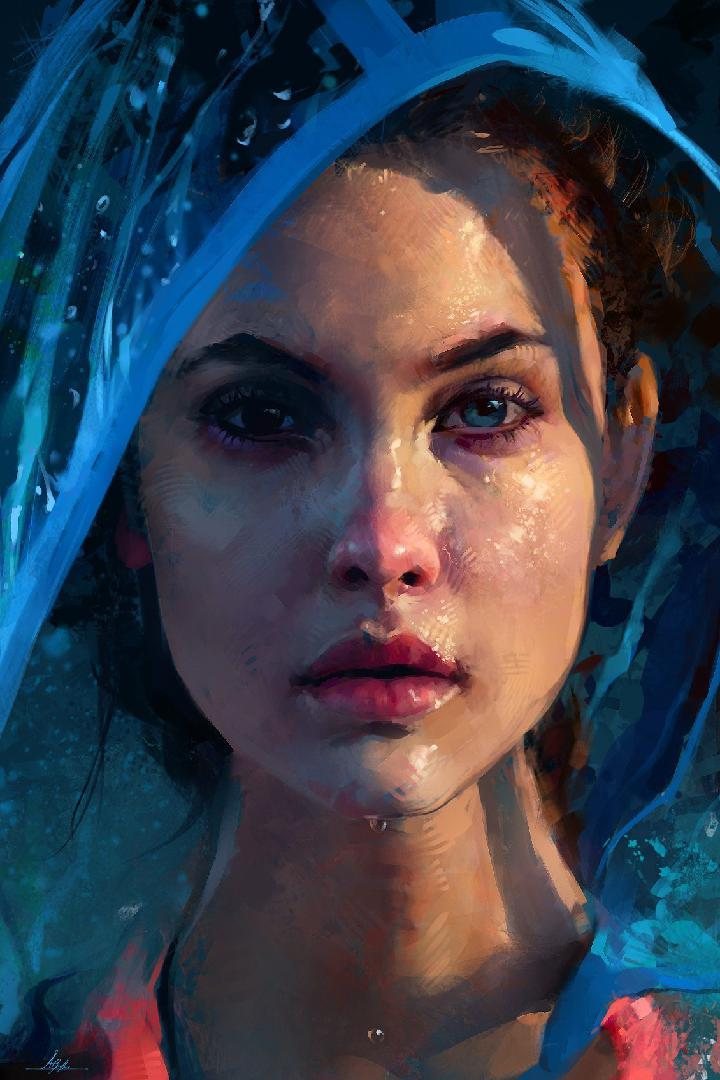

In [23]:
img = PIL.Image.open('lady.jpg')
img=img.resize([720,1080])
img=np.float32(img)
showarray(img)

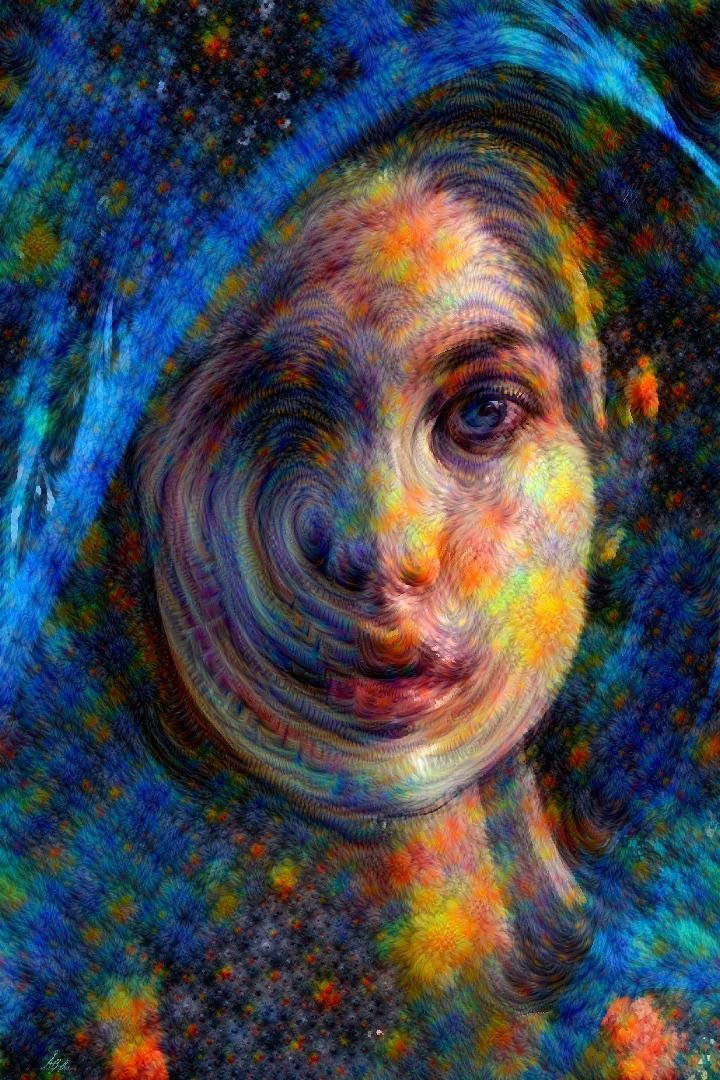

9 9 inception_3b/output (1080, 720, 3)


In [30]:
end = layer[1]
h, w = guide.shape[:2]
src, dst = net.blobs['data'], net.blobs[end]
src.reshape(1,3,h,w)
src.data[0] = preprocess(net, guide)
net.forward(end=end)
guide_features = dst.data[0].copy()

def objective_guide(dst):
    x = dst.data[0].copy()
    y = guide_features
    ch = x.shape[0]
    x = x.reshape(ch,-1)
    y = y.reshape(ch,-1)
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    dst.diff[0].reshape(ch,-1)[:] = y[:,A.argmax(1)] # select ones that match best

output=deepdream(net, img, end=end, objective=objective_guide,octave_n=10,iter_n=10)

In [33]:
PIL.Image.fromarray(np.uint8(output)).save('half_face.jpg')

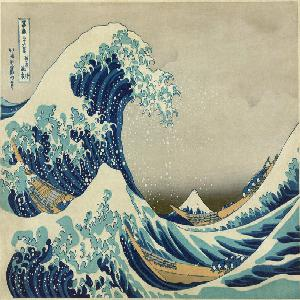

In [74]:
guide = PIL.Image.open('wave.jpg')
guide=guide.resize([300,300])
guide=np.float32(guide)
showarray(guide)

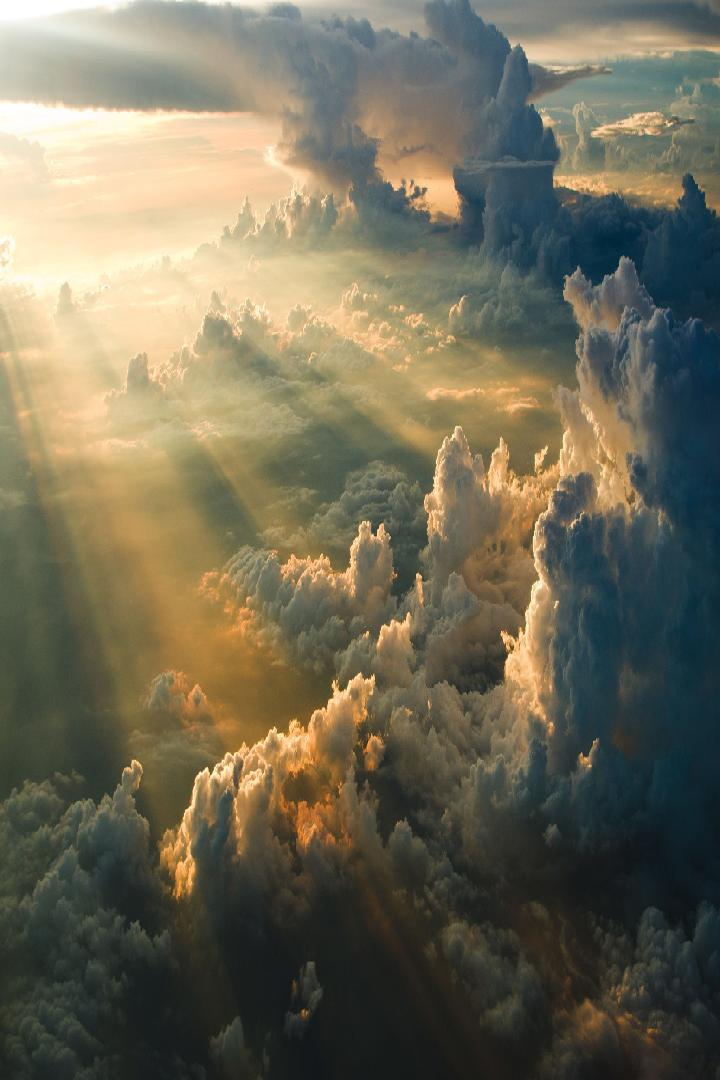

In [75]:
img = PIL.Image.open('sky.jpg')
img=img.resize([720,1080])
img=np.float32(img)
showarray(img)

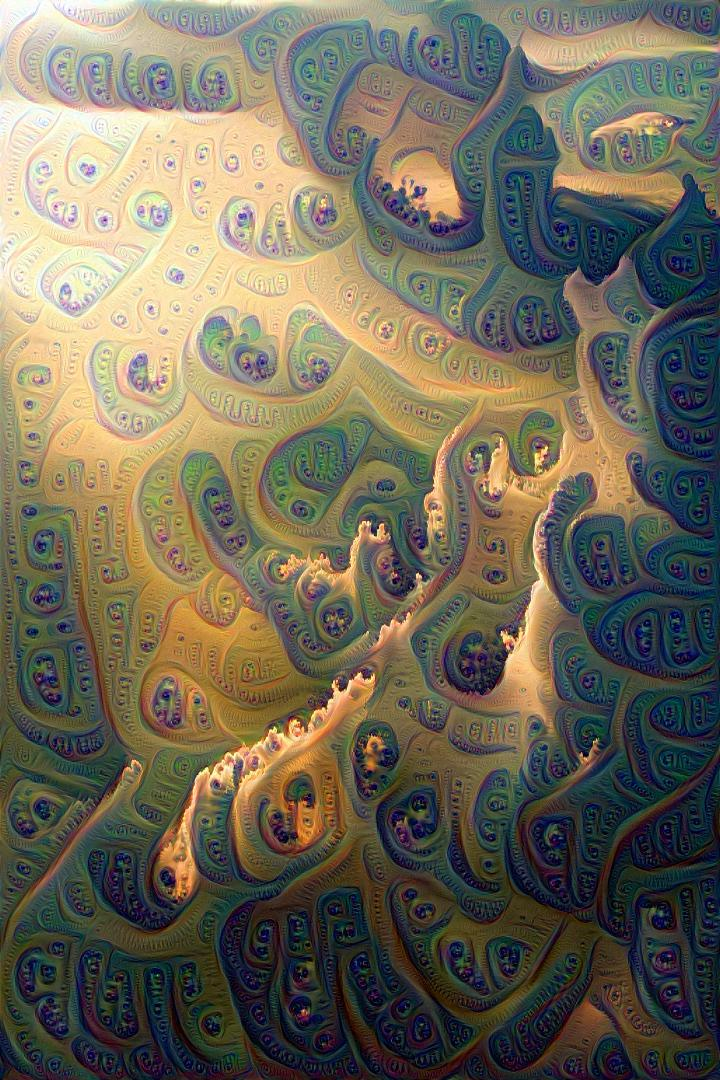

5 9 inception_3a/output (1080, 720, 3)


In [77]:
end = layer[0]
h, w = guide.shape[:2]
src, dst = net.blobs['data'], net.blobs[end]
src.reshape(1,3,h,w)
src.data[0] = preprocess(net, guide)
net.forward(end=end)
guide_features = dst.data[0].copy()

def objective_guide(dst):
    x = dst.data[0].copy()
    y = guide_features
    ch = x.shape[0]
    x = x.reshape(ch,-1)
    y = y.reshape(ch,-1)
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    dst.diff[0].reshape(ch,-1)[:] = y[:,A.argmax(1)] # select ones that match best

output=deepdream(net, img, end=end, objective=objective_guide,octave_n=6,iter_n=10)

In [42]:
PIL.Image.fromarray(np.uint8(output)).save('hollow_sky.jpg')

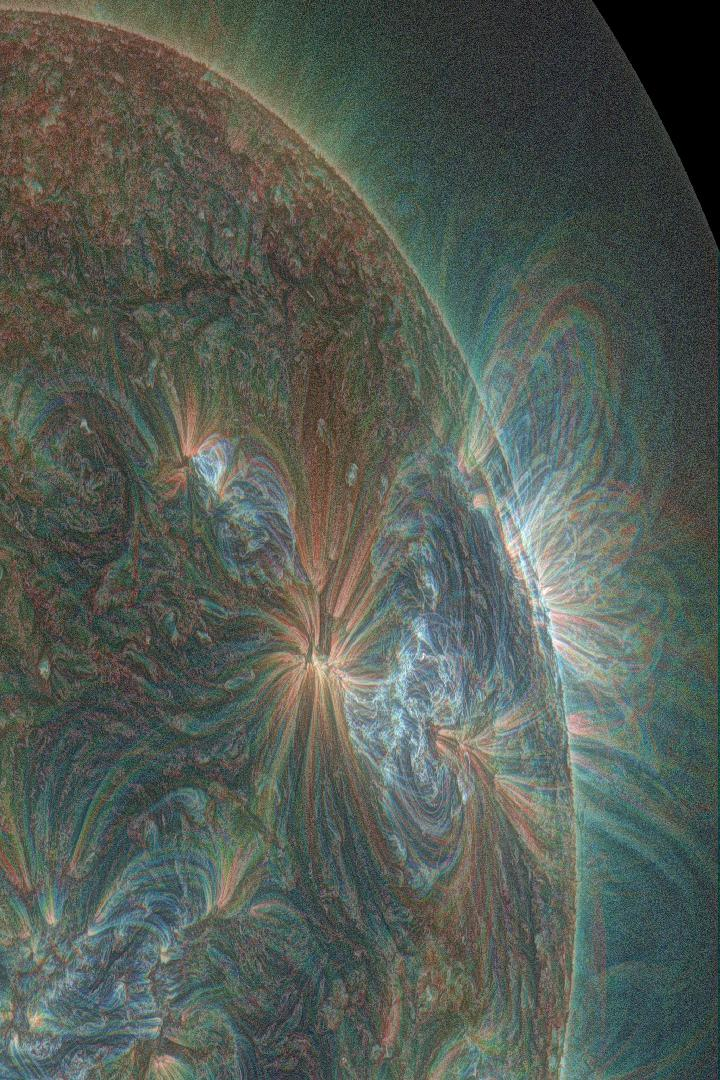

In [109]:
img = PIL.Image.open('sun.jpg')
img=img.resize([720,1080])
img=np.float32(img)
showarray(img)

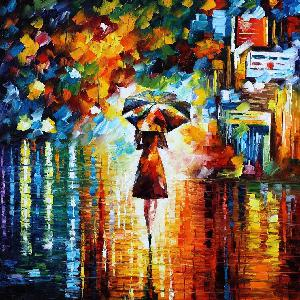

In [110]:
guide = PIL.Image.open('rain.jpg')
guide=guide.resize([300,300])
guide=np.float32(guide)
showarray(guide)

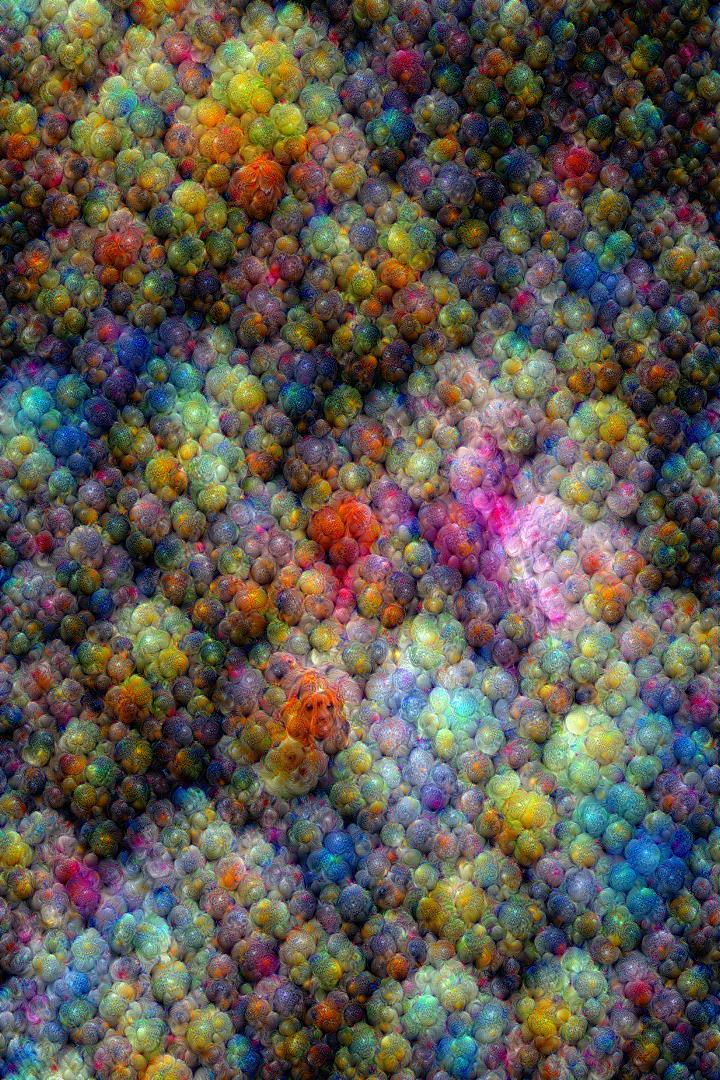

11 29 inception_4a/output (1080, 720, 3)


In [115]:
end = layer[2]
h, w = guide.shape[:2]
src, dst = net.blobs['data'], net.blobs[end]
src.reshape(1,3,h,w)
src.data[0] = preprocess(net, guide)
net.forward(end=end)
guide_features = dst.data[0].copy()

def objective_guide(dst):
    x = dst.data[0].copy()
    y = guide_features
    ch = x.shape[0]
    x = x.reshape(ch,-1)
    y = y.reshape(ch,-1)
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    dst.diff[0].reshape(ch,-1)[:] = y[:,A.argmax(1)] # select ones that match best

output=deepdream(net, img, end=end, objective=objective_guide,octave_n=12,iter_n=30)

In [116]:
PIL.Image.fromarray(np.uint8(output)).save('thing.jpg')